# Tokenization and MultiTok Paper

Name: Almog Zemach

Contact: almog.zemach@post.runi.ac.il

Course: Seminar in Large Language Models and Information Theory (3968)

Supervise: Alon Kipnis

Description:

In this notebook I explores core tokenization strategies used in modern language models such as BERT and GPT. I provide an overview of the Lempel-Ziv-Welch (LZW) compression algorithm and introduces the MultiTok paper, along with its corresponding implementation. Finally, I developed a custom tokenizer based on LZW to compare it with the MultiTok framework.

# Tokenization

## Tokenization Demonstrations

In this section we’ll see how two standard subword tokenizers split text.

## BPE

In [ ]:
corpus = [
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Spitting & Cleanup

In [ ]:
from collections import defaultdict

word_freqs = defaultdict(int)

for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

print(word_freqs)

defaultdict(<class 'int'>, {'This': 2, 'Ġchapter': 1, 'Ġis': 1, 'Ġabout': 1, 'Ġtokenization': 1, '.': 3, 'Ġsection': 1, 'Ġshows': 1, 'Ġseveral': 1, 'Ġtokenizer': 1, 'Ġalgorithms': 1, 'Hopefully': 1, ',': 1, 'Ġyou': 1, 'Ġwill': 1, 'Ġbe': 1, 'Ġable': 1, 'Ġto': 1, 'Ġunderstand': 1, 'Ġhow': 1, 'Ġthey': 1, 'Ġare': 1, 'Ġtrained': 1, 'Ġand': 1, 'Ġgenerate': 1, 'Ġtokens': 1})


In [ ]:
alphabet = []

for word in word_freqs.keys():
    for letter in word:
        if letter not in alphabet:
            alphabet.append(letter)
alphabet.sort()

print(alphabet)

[',', '.', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ']


In [ ]:
vocab = ["<|endoftext|>"] + alphabet.copy()

In [ ]:
splits = {word: [c for c in word] for word in word_freqs.keys()}

Compute the number of occurrences of each successive pair of characters in the dataset.

$(c_1, c_2) \Rightarrow \# occurrences$

In [ ]:
def compute_pair_freqs(splits):
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            pair_freqs[pair] += freq
    return pair_freqs

In [ ]:
pair_freqs = compute_pair_freqs(splits)

for i, key in enumerate(pair_freqs.keys()):
    print(f"{key}: {pair_freqs[key]}")
    if i >= 5:
        break

('T', 'h'): 2
('h', 'i'): 2
('i', 's'): 3
('Ġ', 'c'): 1
('c', 'h'): 1
('h', 'a'): 1


In [ ]:
best_pair = ""
max_freq = None

for pair, freq in pair_freqs.items():
    if max_freq is None or max_freq < freq:
        best_pair = pair
        max_freq = freq

print(best_pair, max_freq)

('Ġ', 't') 6


In [ ]:
merges = {("Ġ", "t"): "Ġt"}
vocab.append("Ġt")

In [ ]:
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue

        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

In [ ]:
splits = merge_pair("Ġ", "t", splits)
print(splits["Ġtrained"])

['Ġt', 'r', 'a', 'i', 'n', 'e', 'd']


In [ ]:
vocab_size = 50

while len(vocab) < vocab_size:
    pair_freqs = compute_pair_freqs(splits)
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq
    splits = merge_pair(*best_pair, splits)
    merges[best_pair] = best_pair[0] + best_pair[1]
    vocab.append(best_pair[0] + best_pair[1])

In [ ]:
print(merges)

{('Ġ', 't'): 'Ġt', ('e', 'r'): 'er', ('Ġ', 'a'): 'Ġa', ('Ġt', 'o'): 'Ġto', ('e', 'n'): 'en', ('i', 's'): 'is', ('Ġto', 'k'): 'Ġtok', ('Ġtok', 'en'): 'Ġtoken', ('Ġ', 's'): 'Ġs', ('n', 'd'): 'nd', ('T', 'h'): 'Th', ('Th', 'is'): 'This', ('Ġa', 'b'): 'Ġab', ('o', 'u'): 'ou', ('Ġtoken', 'i'): 'Ġtokeni', ('Ġtokeni', 'z'): 'Ġtokeniz', ('a', 't'): 'at', ('i', 'o'): 'io', ('io', 'n'): 'ion', ('Ġs', 'e'): 'Ġse', ('h', 'o'): 'ho'}


In [ ]:
print(vocab)

['<|endoftext|>', ',', '.', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ', 'Ġt', 'er', 'Ġa', 'Ġto', 'en', 'is', 'Ġtok', 'Ġtoken', 'Ġs', 'nd', 'Th', 'This', 'Ġab', 'ou', 'Ġtokeni', 'Ġtokeniz', 'at', 'io', 'ion', 'Ġse', 'ho']


In [ ]:
def tokenize(text):
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    splits = [[l for l in word] for word in pre_tokenized_text]
    for pair, merge in merges.items():
        for idx, split in enumerate(splits):
            i = 0
            while i < len(split) - 1:
                if split[i] == pair[0] and split[i + 1] == pair[1]:
                    split = split[:i] + [merge] + split[i + 2 :]
                else:
                    i += 1
            splits[idx] = split

    return sum(splits, [])

In [ ]:
tokenize("This is not a token.")

['This', 'Ġ', 'is', 'Ġ', 'n', 'o', 't', 'Ġa', 'Ġtoken', '.']

## WordPiece

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Splitting & Cleanup

In [ ]:
from collections import defaultdict

word_freqs = defaultdict(int)
for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

word_freqs

defaultdict(int,
            {'This': 2,
             'chapter': 1,
             'is': 1,
             'about': 1,
             'tokenization': 1,
             '.': 3,
             'section': 1,
             'shows': 1,
             'several': 1,
             'tokenizer': 1,
             'algorithms': 1,
             'Hopefully': 1,
             ',': 1,
             'you': 1,
             'will': 1,
             'be': 1,
             'able': 1,
             'to': 1,
             'understand': 1,
             'how': 1,
             'they': 1,
             'are': 1,
             'trained': 1,
             'and': 1,
             'generate': 1,
             'tokens': 1})

In [ ]:
alphabet = []
for word in word_freqs.keys():
    if word[0] not in alphabet:
        alphabet.append(word[0])
    for letter in word[1:]:
        if f"##{letter}" not in alphabet:
            alphabet.append(f"##{letter}")

alphabet.sort()
alphabet

print(alphabet)

['##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##m', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##w', '##y', '##z', ',', '.', 'H', 'T', 'a', 'b', 'c', 'g', 'h', 'i', 's', 't', 'u', 'w', 'y']


In [ ]:
vocab = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"] + alphabet.copy()

In [ ]:
splits = {
    word: [c if i == 0 else f"##{c}" for i, c in enumerate(word)]
    for word in word_freqs.keys()
}

Compute the likelihood of each successive pair of characters

$likelihood(c_1c_2)= \frac{C(c_1c_2)}{C(c_1)\cdot C(c_2)}  \approx \frac{P(c_1c_2)}{P(c_1)\cdot P(c_2)}$

In [ ]:
def compute_pair_scores(splits):
    letter_freqs = defaultdict(int)
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            letter_freqs[split[0]] += freq
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            letter_freqs[split[i]] += freq
            pair_freqs[pair] += freq
        letter_freqs[split[-1]] += freq

    scores = {
        pair: freq / (letter_freqs[pair[0]] * letter_freqs[pair[1]])
        for pair, freq in pair_freqs.items()
    }
    return scores

In [ ]:
pair_scores = compute_pair_scores(splits)
for i, key in enumerate(pair_scores.keys()):
    print(f"{key}: {pair_scores[key]}")
    if i >= 5:
        break

('T', '##h'): 0.16666666666666666
('##h', '##i'): 0.037037037037037035
('##i', '##s'): 0.031746031746031744
('c', '##h'): 0.16666666666666666
('##h', '##a'): 0.027777777777777776
('##a', '##p'): 0.08333333333333333


In [ ]:
best_pair = ""
max_score = None
for pair, score in pair_scores.items():
    if max_score is None or max_score < score:
        best_pair = pair
        max_score = score

print(best_pair, max_score)

('##f', '##u') 0.3333333333333333


In [ ]:
vocab.append("ab")

Replace successive tokens by their combination

In [ ]:
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue
        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                merge = a + b[2:] if b.startswith("##") else a + b
                split = split[:i] + [merge] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

In [ ]:
splits = merge_pair("a", "##b", splits)
splits["about"]

['ab', '##o', '##u', '##t']

In [ ]:
vocab_size = 70
while len(vocab) < vocab_size:
    scores = compute_pair_scores(splits)
    best_pair, max_score = "", None
    for pair, score in scores.items():
        if max_score is None or max_score < score:
            best_pair = pair
            max_score = score
    splits = merge_pair(*best_pair, splits)
    new_token = (
        best_pair[0] + best_pair[1][2:]
        if best_pair[1].startswith("##")
        else best_pair[0] + best_pair[1]
    )
    vocab.append(new_token)

In [ ]:
print(vocab)

['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##m', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##w', '##y', '##z', ',', '.', 'H', 'T', 'a', 'b', 'c', 'g', 'h', 'i', 's', 't', 'u', 'w', 'y', 'ab', '##fu', 'Th', 'ch', '##hm', 'cha', 'chap', 'sh', 'th', 'chapt', '##ct', '##thm', 'is', '##thms', '##lg', 'alg', '##ful', '##full', '##fully', '##ut', '##at', '##ta', '##zat', '##sta', '##ws', '##ra', '##rsta']


In [ ]:
def encode_word(word):
    tokens = []
    while len(word) > 0:
        i = len(word)
        while i > 0 and word[:i] not in vocab:
            i -= 1
        if i == 0:
            return ["[UNK]"]
        tokens.append(word[:i])
        word = word[i:]
        if len(word) > 0:
            word = f"##{word}"
    return tokens

In [ ]:
print(encode_word("Tokenizer"))
print(encode_word("MultiTok"))

['T', '##o', '##k', '##e', '##n', '##i', '##z', '##e', '##r']
['[UNK]']


In [ ]:
def tokenize(text):
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    encoded_words = [encode_word(word) for word in pre_tokenized_text]
    return sum(encoded_words, [])

In [ ]:
tokenize("This is a tokenizer!")

['Th',
 '##i',
 '##s',
 'is',
 'a',
 't',
 '##o',
 '##k',
 '##e',
 '##n',
 '##i',
 '##z',
 '##e',
 '##r',
 '[UNK]']

## BPE vs WordPiece

In [ ]:
sample_sentences = [
    "Alice goes to the Wonderland and Bob goes to the Wonderland Zoo",
    "The quick brown fox jumps over the lazy dog"
]

In [ ]:
from tokenizers import ByteLevelBPETokenizer

bpe = ByteLevelBPETokenizer()
bpe.train_from_iterator(sample_sentences, vocab_size=50, min_frequency=1)

print("BPE tokenization:")
for s in sample_sentences:
    enc = bpe.encode(s)
    print(f"  \"{s}\" → {enc.tokens}")


BPE tokenization:
  "Alice goes to the Wonderland and Bob goes to the Wonderland Zoo" → ['A', 'l', 'i', 'c', 'e', 'Ġ', 'g', 'o', 'e', 's', 'Ġ', 't', 'o', 'Ġ', 't', 'h', 'e', 'Ġ', 'W', 'o', 'n', 'd', 'e', 'r', 'l', 'a', 'n', 'd', 'Ġ', 'a', 'n', 'd', 'Ġ', 'B', 'o', 'b', 'Ġ', 'g', 'o', 'e', 's', 'Ġ', 't', 'o', 'Ġ', 't', 'h', 'e', 'Ġ', 'W', 'o', 'n', 'd', 'e', 'r', 'l', 'a', 'n', 'd', 'Ġ', 'Z', 'o', 'o']
  "The quick brown fox jumps over the lazy dog" → ['T', 'h', 'e', 'Ġ', 'q', 'u', 'i', 'c', 'k', 'Ġ', 'b', 'r', 'o', 'w', 'n', 'Ġ', 'f', 'o', 'x', 'Ġ', 'j', 'u', 'm', 'p', 's', 'Ġ', 'o', 'v', 'e', 'r', 'Ġ', 't', 'h', 'e', 'Ġ', 'l', 'a', 'z', 'y', 'Ġ', 'd', 'o', 'g']


In [ ]:
from transformers import BertTokenizer

wp = BertTokenizer.from_pretrained("bert-base-uncased")
print("\nWordPiece tokenization:")
for s in sample_sentences:
    print(f"  \"{s}\" → {wp.tokenize(s)}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


WordPiece tokenization:
  "Alice goes to the Wonderland and Bob goes to the Wonderland Zoo" → ['alice', 'goes', 'to', 'the', 'wonderland', 'and', 'bob', 'goes', 'to', 'the', 'wonderland', 'zoo']
  "The quick brown fox jumps over the lazy dog" → ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


In [ ]:
demo_sentences = [
    "Unbelievability brings disestablishmentarianism to the forefront.",
    "Pneumonoultramicroscopicsilicovolcanoconiosis is the longest word."
]

In [ ]:
from transformers import GPT2TokenizerFast, BertTokenizer

gpt2 = GPT2TokenizerFast.from_pretrained("gpt2")
bert = BertTokenizer.from_pretrained("bert-base-uncased")

for s in demo_sentences:
    print("SENTENCE:", s)
    print(" GPT-2 BPE:       ", gpt2.tokenize(s))
    print(" BERT WordPiece:  ", bert.tokenize(s))
    print()

SENTENCE: Unbelievability brings disestablishmentarianism to the forefront.
 GPT-2 BPE:        ['Un', 'bel', 'iev', 'ability', 'Ġbrings', 'Ġdis', 'establishment', 'arian', 'ism', 'Ġto', 'Ġthe', 'Ġforefront', '.']
 BERT WordPiece:   ['un', '##bel', '##ie', '##va', '##bility', 'brings', 'di', '##ses', '##ta', '##bl', '##ishment', '##arian', '##ism', 'to', 'the', 'forefront', '.']

SENTENCE: Pneumonoultramicroscopicsilicovolcanoconiosis is the longest word.
 GPT-2 BPE:        ['P', 'neum', 'on', 'oult', 'ram', 'icro', 'sc', 'op', 'ics', 'ilic', 'ov', 'ol', 'can', 'ocon', 'iosis', 'Ġis', 'Ġthe', 'Ġlongest', 'Ġword', '.']
 BERT WordPiece:   ['p', '##ne', '##um', '##ono', '##ult', '##ram', '##ic', '##ros', '##copic', '##sil', '##ico', '##vo', '##lc', '##ano', '##con', '##ios', '##is', 'is', 'the', 'longest', 'word', '.']



# LZW

In [ ]:
import sys
import math
from io import StringIO
from typing import List, Dict, Tuple, Optional
from collections import Counter

## LZW Compression

In [ ]:
def lzw_compress(uncompressed: str) -> list[int]:
    dict_size = 256
    dictionary = {chr(i): i for i in range(dict_size)}

    w = ""
    result: list[int] = []
    for c in uncompressed:
        wc = w + c
        if wc in dictionary:
            w = wc
        else:
            if w not in dictionary:
                w = ""
                continue
            result.append(dictionary[w])
            dictionary[wc] = dict_size
            dict_size += 1
            w = c

    if w and w in dictionary:
        result.append(dictionary[w])
    return result


def lzw_decompress(compressed: list[int]) -> str:
    dict_size = 256
    dictionary = {i: chr(i) for i in range(dict_size)}

    from io import StringIO
    result = StringIO()

    w = chr(compressed.pop(0))
    result.write(w)
    for k in compressed:
        if k in dictionary:
            entry = dictionary[k]
        elif k == dict_size:
            entry = w + w[0]
        else:
            raise ValueError(f"Bad compressed k: {k}")
        result.write(entry)
        dictionary[dict_size] = w + entry[0]
        dict_size += 1
        w = entry

    return result.getvalue()


In [ ]:
def bit_length_needed(codes):
    """Estimate number of bits required per code based on the max code value."""
    max_code = max(codes)
    return math.ceil(math.log2(max_code + 1))


def print_size_comparison(original, compressed_codes):
    original_size_bits = len(original) * 8  # 8 bits per character
    bits_per_code = bit_length_needed(compressed_codes)
    compressed_size_bits = len(compressed_codes) * bits_per_code

    print(f"Original string: {original}")
    print(f"Original size: {original_size_bits} bits")
    print(f"Compressed codes: {compressed_codes}")
    print(f"bits per code: {bits_per_code}")
    print(f"Compressed size: {compressed_size_bits} bits")
    print(f"Saving space: {((1 - compressed_size_bits / original_size_bits) * 100):.2f} %")

In [ ]:
lzw_decompress(lzw_compress("hello world"))

'hello world'

In [ ]:
text = "TOBEORNOTTOBEORTOBEORNOT"
compressed = lzw_compress(text)
print_size_comparison(text, compressed)

Original string: TOBEORNOTTOBEORTOBEORNOT
Original size: 192 bits
Compressed codes: [84, 79, 66, 69, 79, 82, 78, 79, 84, 256, 258, 260, 265, 259, 261, 263]
bits per code: 9
Compressed size: 144 bits
Saving space: 25.00 %


## LZW Vocab Construction

In [ ]:
def build_lzw_vocab(
    sentences: List[str],
    initial_dict_size: int = 256,
    max_dict_size: Optional[int] = None
) -> Tuple[Dict[str,int], Counter]:
    """
    Build a global LZW vocabulary over all sentences **and** count
    how often each phrase is emitted.

    Returns:
      - dictionary: mapping phrase → unique integer code
      - freq: Counter mapping each phrase → number of times it was output
    """
    dict_size = initial_dict_size
    dictionary = {chr(i): i for i in range(initial_dict_size)}
    freq = Counter()

    for text in sentences:
        w = ""
        for c in text:
            wc = w + c
            if wc in dictionary:
                w = wc
            else:
                # emit w
                if w in dictionary:
                    freq[w] += 1
                # add new phrase
                if max_dict_size is None or dict_size < max_dict_size:
                    dictionary[wc] = dict_size
                    dict_size += 1
                w = c
        # emit last w
        if w and w in dictionary:
            freq[w] += 1

    return dictionary, freq

### Vocab Pruning

In [ ]:
def prune_lzw_vocab(
    full_vocab: Dict[str,int],
    freq: Counter,
    max_vocab_size: int,
    min_freq: int = 1
) -> Dict[str,int]:
    """
    Prune an LZW vocabulary so that you keep:
      1) **all** single-character tokens,
      2) plus the most “relevant” multi-character tokens—
         i.e. those with freq >= min_freq,
         sorted by frequency (desc) then length (desc),
         until you hit max_vocab_size.

    Returns:
      A new dict mapping token → new contiguous ID [0..vocab_size-1].
    """
    single_chars = [tok for tok in full_vocab if len(tok) == 1]
    n_single = len(single_chars)
    if max_vocab_size < n_single:
        raise ValueError(
            f"max_vocab_size={max_vocab_size} < number of single-char tokens={n_single}"
        )

    multi = [
        tok for tok, code in full_vocab.items()
        if len(tok) > 1 and freq.get(tok, 0) >= min_freq
    ]

    multi.sort(key=lambda tok: (-freq[tok], -len(tok), full_vocab[tok]))

    slots_left = max_vocab_size - n_single - 1    # -1 due to <unk> token
    chosen_multi = multi[:slots_left]
    chosen_multi.append("<unk>")

    pruned_tokens = single_chars + chosen_multi
    new_vocab = {tok: idx for idx, tok in enumerate(pruned_tokens)}

    return new_vocab

## LZW Encoding

In [ ]:
def lzw_toekn_encoding(text: str, vocab: Dict[str, int]) -> List[int]:
    """
    Encode `text` as a sequence of token IDs using a fixed LZW‐style vocab.
    Always picks the longest matching substring at each position.

    Args:
      text: the input string to tokenize.
      vocab: mapping from token string → integer ID

    Returns:
      List of integer token IDs.
    """
    max_token_len = max(len(tok) for tok in vocab)

    tokens: List[int] = []
    i = 0
    while i < len(text):
        match = None
        for L in range(max_token_len, 0, -1):
            substr = text[i : i + L]
            if substr in vocab:
                match = substr
                tokens.append(vocab[substr])
                i += L
                break

        if match is None:
            tokens.append(vocab["<unk>"])
            i += 1

    return tokens

# MultiTok

In [ ]:
!pip install datasets --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
import pandas as pd
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, BertModel
import random
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn import metrics

## Dataset

### IMDB

In [ ]:
#IMDB
dataset = load_dataset("imdb")
train_sentences = dataset['train']['text']
train_labels = dataset['train']['label']

test_sentences = dataset['test']['text']
test_labels = dataset['test']['label']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
print(train_sentences[5])
print(train_labels[5])

I would put this at the top of my list of films in the category of unwatchable trash! There are films that are bad, but the worst kind are the ones that are unwatchable but you are suppose to like them because they are supposed to be good for you! The sex sequences, so shocking in its day, couldn't even arouse a rabbit. The so called controversial politics is strictly high school sophomore amateur night Marxism. The film is self-consciously arty in the worst sense of the term. The photography is in a harsh grainy black and white. Some scenes are out of focus or taken from the wrong angle. Even the sound is bad! And some people call this art?<br /><br />
0


## Tokenizers

In [ ]:
SMALL_BATCH_SIZE = 64
BATCH_SIZE = 1000

### MultiTok Compression

In [ ]:
def multitok_word_encode(data, dict_values, freeze_dict, window=None):
  if window == None or window ==0:
    window=len(data)

  code = []

  index =0
  count = len(dict_values)

  while index < len(data):
    new_code = ""

    # find word
    for j in range(index + 1, min(len(data)+1, index + 1 + window)):
        word = " ".join(map(str,data[index:j]))

        #Index of longest string in dictionary
        if word in dict_values:
          new_code = str(dict_values[word])

        #Adding new val to dictionary
        if word not in dict_values:
            if not freeze_dict:
              dict_values[word] = count
              count += 1
            index += len(data[index:j]) -1
            break

        #Reached last word
        if j >= len(data) or j>= index + window:
          index += len(data[index:j])
          break

    code.append(int(new_code))

  return code

### Random Tokenizer

In [ ]:
RANDOM_DATA_SIZE = 10000
VOCAB_SIZE_RANDOM = 100000

In [ ]:
def random_tokens():
  print("Initializing Random Tokenizer")
  exp1_dataX= []
  exp_dataY= []

  for i in range (RANDOM_DATA_SIZE):
    exp1_dataX.append(random.sample(range(0, VOCAB_SIZE_RANDOM), 150))
    exp_dataY.append([random.randint(0,1)])

  X1 = torch.tensor(exp1_dataX)
  Y = torch.tensor(exp_dataY)

  Y = Y.to(torch.float32)

  loader = DataLoader(list(zip(X1, Y)), shuffle=True, batch_size=BATCH_SIZE)

  #Evalutation
  exp1_testX = []
  exp_testY = []

  for i in range (RANDOM_DATA_SIZE):
    exp1_testX.append(random.sample(range(0, VOCAB_SIZE_RANDOM), 150))
    exp_testY.append([random.randint(0,1)])

  test_X1 = torch.tensor(exp1_testX)
  test_Y = torch.tensor(exp_testY)

  return X1, Y, loader, test_X1, test_Y, VOCAB_SIZE_RANDOM

### Bert Tokenizer

In [ ]:
VOCAB_SIZE_BERT = 30522

In [ ]:
def bert_tokens(train_sentences, train_labels, test_sentences, test_labels):
  print("Initializing Bert Tokenizer")
  tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

  #Create own embeddings with available unique words.
  exp1_dataX= []
  exp_dataY= []

  #Create tokens
  max_len = 0
  for i in range (len(train_sentences)):
    sentence_tokens = tokenizer.encode(train_sentences[i], max_length = tokenizer.model_max_length, truncation=True)

    max_len = max(max_len, len(sentence_tokens))


    exp1_dataX.append(sentence_tokens)
    exp_dataY.append([train_labels[i]])

  #padding
  X_padded = [val + [0]*(max_len - len(val)) for val in exp1_dataX]

  X1 = torch.tensor(X_padded)
  Y = torch.tensor(exp_dataY)

  Y = Y.to(torch.float32)

  loader = DataLoader(list(zip(X1, Y)), shuffle=True, batch_size=BATCH_SIZE)

  print("Finished Preprocessing, ", "Max Length:", max_len)

  #Evalutation
  exp1_testX = []
  exp_testY = []

  #Create tokens
  for i in range (len(test_sentences)):
    sentence_tokens = tokenizer.encode(test_sentences[i], max_length = tokenizer.model_max_length, truncation=True)
    if len(sentence_tokens) <= max_len:
      exp1_testX.append(sentence_tokens)
      exp_testY.append([test_labels[i]])

  #padding
  testX_padded = [val + [0]*(max_len - len(val)) for val in exp1_testX]

  test_X1 = torch.tensor(testX_padded)
  test_Y = torch.tensor(exp_testY)

  return X1, Y, loader, test_X1, test_Y, VOCAB_SIZE_BERT

### MultiTok Tokenizer

In [ ]:
def multitok_tokens(train_sentences, train_labels, test_sentences, test_labels, input_window, output_window):
  print("Initializing MultiTok Tokenizer")
  #Create own embeddings with available unique words.
  exp1_dataX= []
  exp_dataY= []

  #Build unique dictionary
  num_words = 0
  count = 0
  raw_dict_input = {}
  for sentence in train_sentences:
    for word in sentence.split():
      num_words += 1
      if word not in raw_dict_input:
        raw_dict_input[word] = count
        count += 1

  for sentence in test_sentences:
    for word in sentence.split():
      if word not in raw_dict_input:
        raw_dict_input[word] = count
        count += 1

  words = list(raw_dict_input.keys())
  random.shuffle(words)

  dict_input = dict(zip(words, raw_dict_input.values()))


  #Create tokens
  max_len = 0
  compressed_words = 0
  for i in range (len(train_sentences)):
    vals = multitok_word_encode(train_sentences[i].split(), dict_input, False, input_window)
    compressed_words += len(vals)
    max_len = max(max_len, len(vals))
    exp1_dataX.append(vals)
    exp_dataY.append([train_labels[i]])


  #padding
  X_padded = [val + [0]*(max_len - len(val)) for val in exp1_dataX]

  X1 = torch.tensor(X_padded)
  Y = torch.tensor(exp_dataY)
  Y = Y.to(torch.float32)

  shuffled = list(zip(X1, Y))
  random.shuffle(shuffled)
  loader = DataLoader(shuffled, shuffle=True, batch_size=SMALL_BATCH_SIZE)

  print("Finished Preprocessing, ", "Max Length:", max_len)
  print("Compression Ratio: ", compressed_words/num_words, compressed_words, num_words)

  #Evalutation
  exp1_testX = []
  exp_testY = []

  #Create tokens
  for i in range (len(test_sentences)):
    sentence_tokens = multitok_word_encode(test_sentences[i].split(), dict_input, True, output_window)
    if len(sentence_tokens) <= max_len:
      exp1_testX.append(sentence_tokens)
      exp_testY.append([test_labels[i]])

  #padding
  testX_padded = [val + [0]*(max_len - len(val)) for val in exp1_testX]

  test_X1 = torch.tensor(testX_padded)
  test_Y = torch.tensor(exp_testY)

  return X1, Y, loader, test_X1, test_Y, len(dict_input)

### Bert + MultiTok

In [ ]:
def bert_multitok_tokens(train_sentences, train_labels, test_sentences, test_labels, input_window, output_window):
  print("Initializing Bert + MultiTok Tokenizer")
  tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

  #MultiTok on Bert embeddings
  exp1_dataX= []
  exp1_dataY= []

  #generate dictionary
  dict_input = {}
  for i in range (0, 30523):
    dict_input[str(i)] = i

  num_words = 0
  compressed_words = 0
  max_len = 0
  for i in range(len(train_sentences)):
    sentence_tokens = tokenizer.encode(train_sentences[i], max_length = tokenizer.model_max_length, truncation=True)
    vals = multitok_word_encode(sentence_tokens, dict_input, False, input_window)

    num_words += len(sentence_tokens)
    compressed_words += len(vals)

    max_len = max(max_len, len(vals))

    exp1_dataX.append(vals)
    exp1_dataY.append([train_labels[i]])

  print(len(dict_input))

  #padding
  X_padded = [val + [0]*(max_len - len(val)) for val in exp1_dataX]

  X1 = torch.tensor(X_padded)
  Y = torch.tensor(exp1_dataY)
  Y = Y.to(torch.float32)

  loader = DataLoader(list(zip(X1, Y)), shuffle=True, batch_size=BATCH_SIZE)

  print("Finished Preprocessing, ", "Max Length:", max_len)
  print("Compression Ratio: ", compressed_words/num_words, compressed_words, num_words)

  #Evalutation
  exp1_testX = []
  exp1_testY = []

  #Create tokens
  for i in range (len(test_sentences)):
    bert_tokens = tokenizer.encode(test_sentences[i], max_length = tokenizer.model_max_length, truncation=True)
    sentence_tokens = multitok_word_encode(bert_tokens, dict_input, True, output_window)
    # sentence_tokens = bert_tokens
    if len(sentence_tokens) <= max_len:
      exp1_testX.append(sentence_tokens)
      exp1_testY.append([test_labels[i]])

  #padding
  testX_padded = [val + [0]*(max_len - len(val)) for val in exp1_testX]

  test_X1 = torch.tensor(testX_padded)
  test_Y = torch.tensor(exp1_testY)

  return X1, Y, loader, test_X1, test_Y, len(dict_input)

### MultiTok + Frequency Proning

In [ ]:
def multitok_freq_tokens(train_sentences, train_labels, test_sentences, test_labels, input_window, output_window):
  print("Initializing MultiTok Frequency Tokenizer")
  #Create own embeddings with available unique words.
  exp1_dataX= []
  exp_dataY= []

  #Build unique dictionary
  num_words = 0
  count = 0
  raw_dict_input = {}
  for sentence in train_sentences:
    for word in sentence.split():
      num_words += 1
      if word not in raw_dict_input:
        raw_dict_input[word] = count
        count += 1

  for sentence in test_sentences:
    for word in sentence.split():
      if word not in raw_dict_input:
        raw_dict_input[word] = count
        count += 1

  words = list(raw_dict_input.keys())
  random.shuffle(words)

  dict_input = dict(zip(words, raw_dict_input.values()))

  #Create tokens
  max_len = 0
  for i in range (len(train_sentences)):
    vals = multitok_word_encode(train_sentences[i].split(), dict_input, False, input_window)
    exp1_dataX.append(vals)
    exp_dataY.append([train_labels[i]])


  token_freq = {}
  for entry in exp1_dataX:
    for token in entry:
      if token in token_freq:
        token_freq[token] += 1
      else:
        token_freq[token] = 1

  df = pd.DataFrame(token_freq.items(), columns=['Token', 'Frequency'])
  print(df['Frequency'].describe())
  print(df['Frequency'].value_counts(normalize=True))

  new_dict = {}
  inv_dict = dict(zip(dict_input.values(), dict_input.keys()))
  print("Original Dict size: " + str(len(inv_dict)))

  num_removed = 0
  for token in inv_dict.keys():
    if token in token_freq and token_freq[token] < 2:
      new_token = []
      for tok in inv_dict[token].split():
        new_token.append(dict_input[tok])
      new_dict[token] = new_token

      if len(inv_dict[token].split()) > 1:
        del dict_input[inv_dict[token]]
        num_removed += 1

    else:
      new_dict[token] = [token]
  print("Number of Removed tokens: " + str(num_removed))

  #update dictionary
  smaller_dict = {}
  count = 1
  for val in dict_input.values():
    smaller_dict[val] = count
    count+=1
  print("New Dict size: " + str(len(smaller_dict)))


  new_exp1_dataX = []
  compressed_words = 0
  for sentence in exp1_dataX:
    new_sentence = []
    for word in sentence:
      new_sentence += new_dict[word]

    compressed_words += len(new_sentence)
    max_len = max(max_len, len(new_sentence))
    new_exp1_dataX.append(new_sentence)

  for i in range(len(new_exp1_dataX)):
    for j in range(len(new_exp1_dataX[i])):
      new_exp1_dataX[i][j] = smaller_dict[new_exp1_dataX[i][j]]


  #padding
  X_padded = [val + [0]*(max_len - len(val)) for val in new_exp1_dataX]

  X1 = torch.tensor(X_padded)
  Y = torch.tensor(exp_dataY)

  Y = Y.to(torch.float32)

  shuffled = list(zip(X1, Y))
  random.shuffle(shuffled)
  loader = DataLoader(shuffled, shuffle=True, batch_size=SMALL_BATCH_SIZE)

  print("Finished Preprocessing, ", "Max Length:", max_len)
  print("Compression Ratio: ", compressed_words/num_words, compressed_words, num_words)

  #Evalutation
  exp1_testX = []
  exp_testY = []

  #Create tokens
  for i in range (len(test_sentences)):
    sentence_tokens = multitok_word_encode(test_sentences[i].split(), dict_input, True, output_window)

    new_sentence_tokens = []
    for word in sentence_tokens:
      new_sentence_tokens += new_dict[word]

    if len(new_sentence_tokens) <= max_len:
      exp1_testX.append(new_sentence_tokens)
      exp_testY.append([test_labels[i]])

  for i in range(len(exp1_testX)):
    for j in range(len(exp1_testX[i])):
      exp1_testX[i][j] = smaller_dict[exp1_testX[i][j]]

  #padding
  testX_padded = [val + [0]*(max_len - len(val)) for val in exp1_testX]

  test_X1 = torch.tensor(testX_padded)
  test_Y = torch.tensor(exp_testY)

  return X1, Y, loader, test_X1, test_Y, len(dict_input)


### LZW Tokenizer

In [ ]:
from collections import Counter
import pandas as pd
import torch
from torch.utils.data import DataLoader
from typing import List, Tuple

def lzw_tokens(
    train_sentences: List[str],
    train_labels: List[float],
    test_sentences: List[str],
    test_labels: List[float],
    max_vocab_size: int,
    min_freq: int = 1,
    batch_size: int = SMALL_BATCH_SIZE,
    initial_dict_size: int = 256,
    max_dict_size: int = None,
):
    """
    1) Build & prune an LZW vocab on the training data.
    2) Encode train & test with the pruned vocab.
    3) Pad to the same length, build DataLoader.
    Returns: X1, Y, loader, test_X1, test_Y, vocab_size
    """
    print("Initializing LZW Tokenizer")

    full_vocab, freq = build_lzw_vocab(
        train_sentences,
        initial_dict_size=initial_dict_size,
        max_dict_size=max_dict_size
    )

    pruned_vocab = prune_lzw_vocab(
        full_vocab,
        freq,
        max_vocab_size=max_vocab_size,
        min_freq=min_freq
    )
    dict_size = len(pruned_vocab)
    print(f"Pruned vocab to {dict_size} tokens "
          f"({initial_dict_size} single‐chars + {dict_size-initial_dict_size} substrings)")

    expX, expY = [], []
    total_chars, total_codes = 0, 0
    for s, lbl in zip(train_sentences, train_labels):
        codes = lzw_toekn_encoding(s, pruned_vocab)
        expX.append(codes)
        expY.append([lbl])
        total_chars += len(s)
        total_codes += len(codes)

    token_freq = Counter(tok for seq in expX for tok in seq)
    df = pd.DataFrame(token_freq.items(), columns=["Token", "Frequency"])
    print(df["Frequency"].describe())
    print(df["Frequency"].value_counts(normalize=True))

    print(f"Total chars: {total_chars}, total codes: {total_codes}")
    print(f"Compression ratio (codes/chars): {total_codes/total_chars:.3f}")

    max_len = max(len(seq) for seq in expX)
    X_pad = [seq + [0] * (max_len - len(seq)) for seq in expX]
    X1 = torch.tensor(X_pad, dtype=torch.long)
    Y  = torch.tensor(expY, dtype=torch.float32)
    loader = DataLoader(list(zip(X1, Y)), shuffle=True, batch_size=batch_size)

    expX_t, expY_t = [], []
    for s, lbl in zip(test_sentences, test_labels):
        codes = lzw_toekn_encoding(s, pruned_vocab)
        if len(codes) <= max_len:
            expX_t.append(codes)
            expY_t.append([lbl])

    Xt_pad = [seq + [0] * (max_len - len(seq)) for seq in expX_t]
    test_X1 = torch.tensor(Xt_pad, dtype=torch.long)
    test_Y  = torch.tensor(expY_t, dtype=torch.float32)

    print("Done. Vocabulary size:", dict_size)
    return X1, Y, loader, test_X1, test_Y, dict_size


## Model

In [ ]:
class SimpleTransformer(nn.Module):
    def __init__(self, input_dim=50257, embed_dim=100, num_heads=2, seq_len=512, output_dim=1):
        super(SimpleTransformer, self).__init__()
        # Input embedding
        self.embedding = nn.Embedding(input_dim, embed_dim)

        # Simple self-attention mechanism
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)

        # Simple feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.ReLU(),
            nn.Linear(embed_dim * 2, embed_dim)
        )

        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.layer_norm2 = nn.LayerNorm(embed_dim)

        # Output classifier
        self.fc = nn.Linear(embed_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

        # Positional Encoding
        self.positional_encoding = self._generate_positional_encoding(seq_len, embed_dim)

    # Basic positional encoding (sinusoidal)
    def _generate_positional_encoding(self, seq_len, embed_dim):
        position = torch.arange(seq_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(torch.log(torch.tensor(10000.0)) / embed_dim))
        pe = torch.zeros(seq_len, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        return pe

    def forward(self, x):
        # Embedding input and adding positional encoding
        x = self.embedding(x) + self.positional_encoding[:, :x.size(1), :].to(x.device)

        # Self-attention
        x = x.permute(1, 0, 2)  # Convert (batch_size, seq_len, embed_dim) to (seq_len, batch_size, embed_dim)
        attn_output, _ = self.attention(x, x, x)

        # Add residual connection and normalize
        x = self.layer_norm1(x + attn_output)

        # Feed-forward network
        ff_output = self.ffn(x)

        # Add residual connection and normalize
        x = self.layer_norm2(x + ff_output)

        # Use only the last time step for classification
        x = x[-1, :, :]

        # Final output layer and sigmoid for binary classification
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

## Keras Model

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

class SimpleTransformerOpt(Model):
    def __init__(
        self,
        vocab_size: int = 50257,
        embed_dim: int   = 100,
        num_heads: int   = 2,
        seq_len: int     = 512,
        output_dim: int  = 1
    ):
        super().__init__()
        self.token_emb = layers.Embedding(vocab_size, embed_dim)

        self.seq_len   = seq_len
        self.embed_dim = embed_dim
        self.pos_encoding = self._build_sinusoidal_encoding(seq_len, embed_dim)

        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=0.0
        )

        self.ffn = tf.keras.Sequential([
            layers.Dense(embed_dim * 2, activation="relu"),
            layers.Dense(embed_dim),
        ])

        self.ln1  = layers.LayerNormalization(epsilon=1e-6)
        self.ln2  = layers.LayerNormalization(epsilon=1e-6)

        self.head = layers.Dense(output_dim, activation="sigmoid")

    def _build_sinusoidal_encoding(self, seq_len, d_model):
        """Create a (1, seq_len, d_model) tensor with sinusoidal encodings."""
        pos = np.arange(seq_len)[:, np.newaxis]            # (seq_len, 1)
        i   = np.arange(d_model)[np.newaxis, :]            # (1, d_model)
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / d_model)
        angle_rads  = pos * angle_rates                     # (seq_len, d_model)

        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]          # (1, seq_len, d_model)
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x, training=False):
        seq_len = tf.shape(x)[1]

        x = self.token_emb(x)  # (batch, seq_len, embed_dim)
        x += self.pos_encoding[:, :seq_len, :]

        attn = self.mha(
            query=x, value=x, key=x,
            return_attention_scores=False,
            training=training
        )
        x = self.ln1(x + attn)

        ffn_out = self.ffn(x, training=training)
        x = self.ln2(x + ffn_out)

        x = x[:, -1, :]
        return self.head(x)


## Training

In [ ]:
def train_eval(
    X1, Y, loader,
    test_X1, test_Y,
    input_dim,
    n_epochs,
    device
):
    history = {'train_loss': [], 'train_acc': [], 'test_acc': []}
    all_fpr = []
    all_tpr = []
    all_auc = []

    model     = SimpleTransformer(input_dim, seq_len=X1.size(1)).to(device)
    loss_fn   = nn.BCELoss()
    optimiser = optim.Adam(model.parameters(), lr=1e-2)

    test_loader = DataLoader(list(zip(test_X1, test_Y)), shuffle=True, batch_size=loader.batch_size)
    for epoch in range(1, n_epochs+1):
        # ---- TRAIN ----
        model.train()
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimiser.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            optimiser.step()

        # ---- EVAL ----
        model.eval()
        with torch.no_grad():
            # train acc
            corr, tot = 0, 0
            for xb, yb in loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).round()
                corr += (preds == yb).sum().item()
                tot  += yb.size(0)
            train_acc = corr / tot

            # test acc
            corr, tot = 0, 0
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).round()
                corr += (preds == yb).sum().item()
                tot  += yb.size(0)
            test_acc = corr / tot

        history['train_loss'].append(loss.item())
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        print(f"Epoch {epoch:2d} │ "
              f"Loss {loss.item():.4f} │ "
              f"Train Acc {train_acc:.4f} │ "
              f"Test Acc {test_acc:.4f}")

    # collect ROC for this run
    model.eval()
    with torch.no_grad():
        scores, labels = [], []
        for xb, yb in test_loader:
            xb = xb.to(device)
            scores.append(model(xb).cpu())
            labels.append(yb)
        y_scores = torch.cat(scores).numpy().ravel()
        y_true   = torch.cat(labels).numpy().ravel()

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score   = metrics.auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(auc_score)

    # clean up
    del model, optimiser, loss_fn
    torch.cuda.empty_cache()

    return history, all_fpr, all_tpr, all_auc

In [ ]:
def plot_all(histories, rocs, labels):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
    for hist, lbl in zip(histories, labels):
        axes[0].plot(hist['train_acc'], label=lbl)
        axes[1].plot(hist['train_loss'], label=lbl)
        axes[2].plot(hist['test_acc'],  label=lbl)

    axes[0].set_title("Train Acc"); axes[0].set_ylabel("Accuracy")
    axes[1].set_title("Train Loss");                   axes[1].set_ylabel("Loss")
    axes[2].set_title("Test Acc");  axes[2].set_xlabel("Epoch"); axes[2].set_ylabel("Accuracy")
    for ax in axes: ax.legend()
    plt.tight_layout()
    plt.show()

    # ROC curves
    plt.figure(figsize=(6,6))
    for (fpr_list, tpr_list, auc_list), lbl in zip(rocs, labels):
        # if you ran multiple iterations, you might average tpr/fpr or pick the last
        plt.plot(fpr_list[-1], tpr_list[-1], label=f"{lbl} (AUC={auc_list[-1]:.2f})")
    plt.plot([0,1], [0,1], 'k--', alpha=0.3)
    plt.title("ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

labels = [
    "multitok-freq-tokens",
    "multitok-tokens",
    "random-tokens",
    "bert-tokens",
    "bert-multitok-tokens"
]
loader_fns = [
    lambda: multitok_freq_tokens(train_sentences, train_labels, test_sentences, test_labels, 2, 1),
    lambda: multitok_tokens(train_sentences, train_labels, test_sentences, test_labels, None, None),
    lambda: random_tokens(),
    lambda: bert_tokens(train_sentences, train_labels, test_sentences, test_labels),
    lambda: bert_multitok_tokens(train_sentences, train_labels, test_sentences, test_labels, 2, 1),
]

all_histories = []
all_rocs       = []
for fn in loader_fns:
    X1, Y, loader, tX1, tY, vocab_size = fn()
    hist, fprs, tprs, aucs = train_eval(
        X1, Y, loader,
        tX1, tY,
        input_dim=vocab_size,
        n_epochs=20,
        device=device
    )
    all_histories.append(hist)
    all_rocs.append((fprs, tprs, aucs))

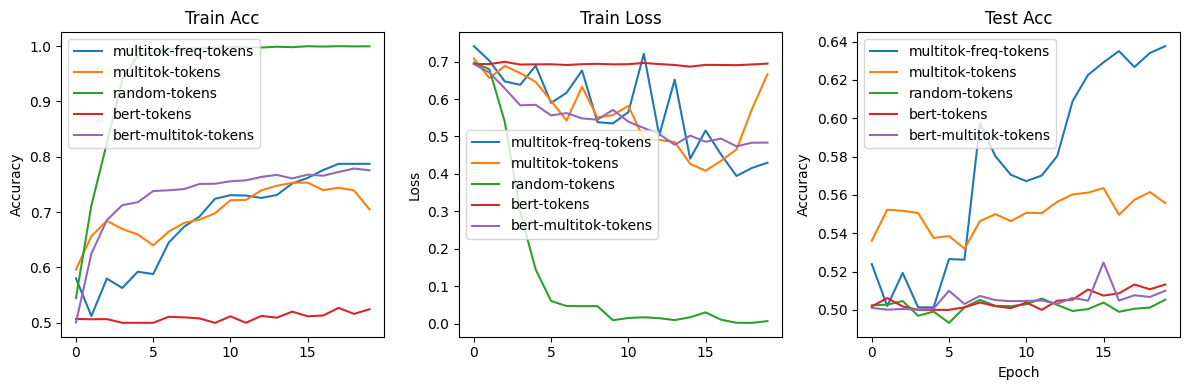

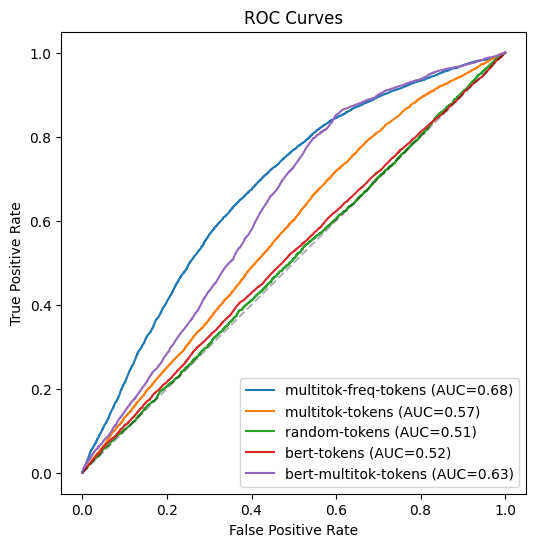

In [ ]:
plot_all(all_histories, all_rocs, labels)

## Initiative: LZW-Based Tokenization

### Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

labels = [
    # "lzw",
]
loader_fns = [
    # lambda: lzw_tokens(train_sentences, train_labels, test_sentences,  test_labels, max_vocab_size=10000, min_freq=15),
]

Using device: cuda



In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, auc

In [ ]:
def train_eval_opt_model_keras(
    X_train, y_train,
    X_test,  y_test,
    input_dim,
    seq_len,
    n_epochs=20,
    batch_size=64,
    lr=1e-2
):
    """
    - X_train, X_test: np.ndarray of shape (N, seq_len), dtype int32
    - y_train, y_test: np.ndarray of shape (N, 1), dtype float32
    """
    model = SimpleTransformerOpt(
        vocab_size=input_dim,
        embed_dim=100,
        num_heads=2,
        seq_len=seq_len,
        output_dim=1
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    train_ds = (
        tf.data.Dataset.from_tensor_slices((X_train, y_train))
        .shuffle(buffer_size=len(X_train))
        .batch(batch_size)
    )
    test_ds = (
        tf.data.Dataset.from_tensor_slices((X_test, y_test))
        .batch(batch_size)
    )

    hist = model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=n_epochs,
        verbose=2
    )

    y_scores = model.predict(X_test, batch_size=batch_size).ravel()
    y_true   = y_test.ravel().astype(int)

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score   = auc(fpr, tpr)

    return {
        'train_loss': hist.history['loss'],
        'train_acc':  hist.history['accuracy'],
        'test_acc':   hist.history['val_accuracy'] # Corrected from hist.his
        }, (fpr, tpr, auc_score) # Added return of roc_curve data

In [ ]:
all_histories = []
all_rocs       = []

for fn in loader_fns:
    X1, Y, loader, tX1, tY, vocab_size = fn()

    X1_np = X1.numpy()
    y1_np = Y.numpy().astype(np.float32)
    X2_np = tX1.numpy()
    y2_np = tY.numpy().astype(np.float32)

    hist, (fpr, tpr, auc_score) = train_eval_opt_model_keras(
        X1_np, y1_np,
        X2_np, y2_np,
        input_dim=vocab_size,
        seq_len=X1_np.shape[1],
        n_epochs=20,
        batch_size=loader.batch_size,
        lr=1e-3
    )

    all_histories.append(hist)
    all_rocs.append((fpr, tpr, auc_score))

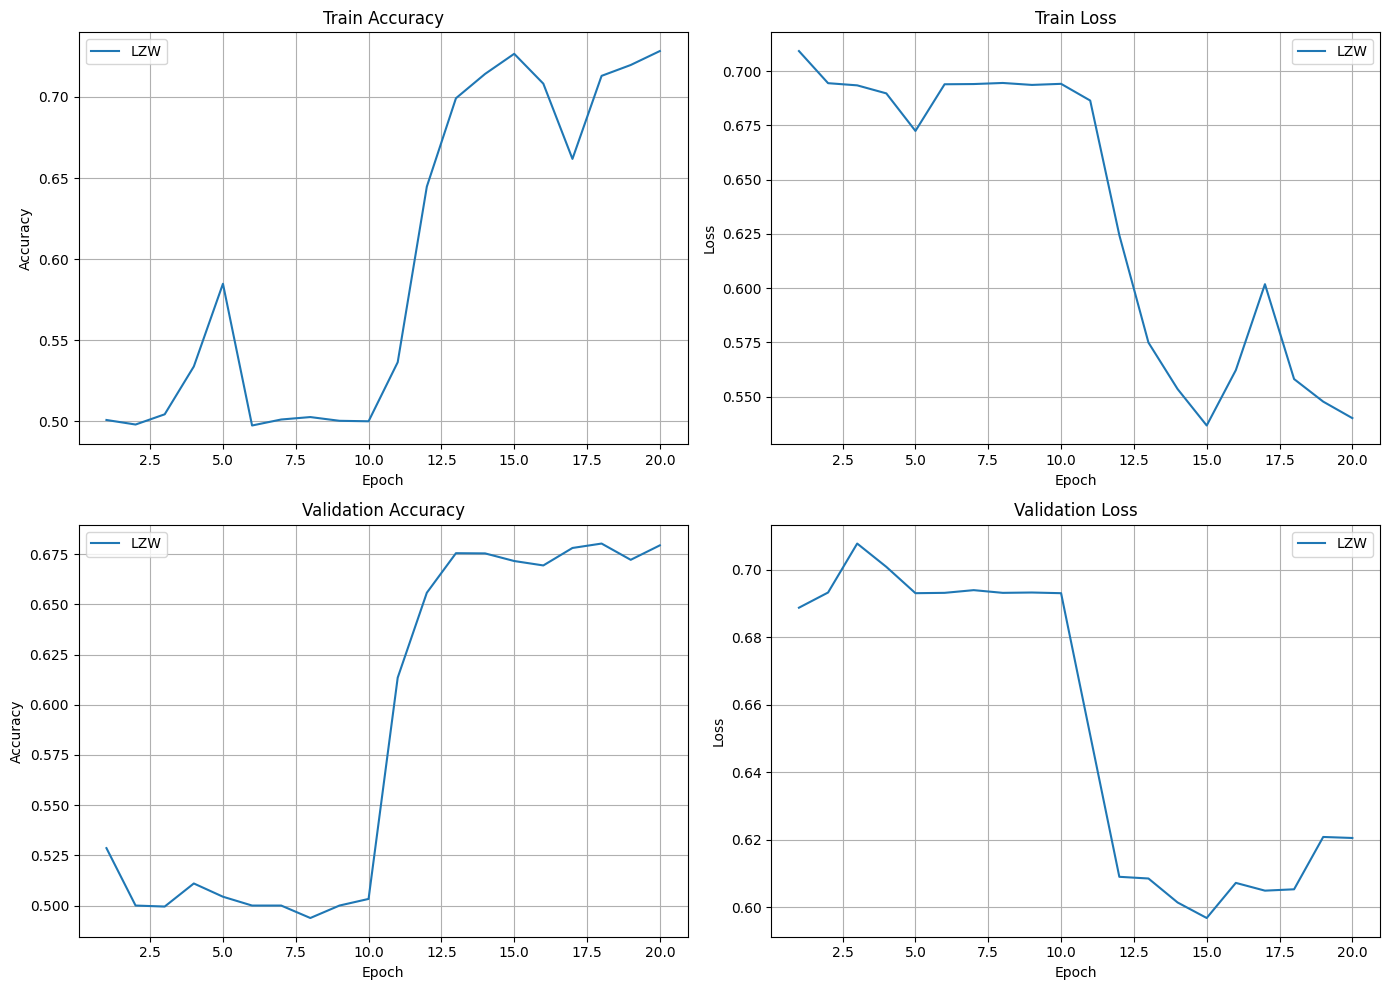

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

lzw_df   = (
    pd.read_csv('Training_Log_Metrics__lr_1e-3_LZW.csv')
      .drop(columns=['Unnamed: 0'], errors='ignore')
      .rename(columns=str.strip)
)

EPOCH      = 'Epoch'
TRAIN_ACC  = 'Train Accuracy'
VAL_ACC    = 'Val Accuracy'
TRAIN_LOSS = 'Train Loss'
VAL_LOSS   = 'Val Loss'

lzw_df[EPOCH]   = pd.to_numeric(lzw_df[EPOCH])

fig, axes = plt.subplots(2, 2, figsize=(14,10))

axes[0,0].plot(lzw_df[EPOCH],   lzw_df[TRAIN_ACC],  label='LZW')
axes[0,0].set_title('Train Accuracy')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()
axes[0,0].grid(True)

axes[0,1].plot(lzw_df[EPOCH],   lzw_df[TRAIN_LOSS],  label='LZW')
axes[0,1].set_title('Train Loss')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()
axes[0,1].grid(True)

axes[1,0].plot(lzw_df[EPOCH],   lzw_df[VAL_ACC],    label='LZW')
axes[1,0].set_title('Validation Accuracy')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Accuracy')
axes[1,0].legend()
axes[1,0].grid(True)

axes[1,1].plot(lzw_df[EPOCH],   lzw_df[VAL_LOSS],    label='LZW')
axes[1,1].set_title('Validation Loss')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Loss')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()


### LZW Training Info

Initializing LZW Tokenizer

Pruned vocab to 10000 tokens (256 single‐chars + 9744 substrings)



```
count     9374.000000
mean       871.494879
std       2692.074702
min          1.000000
25%         48.000000
50%        233.000000
75%        653.750000
max      66482.000000
Name: Frequency, dtype: float64
Frequency
1       0.027416
2       0.022082
3       0.014295
4       0.013761
5       0.011735
          ...   
1265    0.000107
1302    0.000107
767     0.000107
932     0.000107
949     0.000107
```


Name: proportion, Length: 2234, dtype: float64

Total chars: 33126741, total codes: 8169393

Compression ratio (codes/chars): 0.247

Done. Vocabulary size: 10000
```
Epoch 1/20
782/782 - 647s - 827ms/step - accuracy: 0.5008 - loss: 0.7092 - val_accuracy: 0.5286 - val_loss: 0.6887
Epoch 2/20
782/782 - 588s - 751ms/step - accuracy: 0.4980 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/20
782/782 - 548s - 700ms/step - accuracy: 0.5043 - loss: 0.6934 - val_accuracy: 0.4995 - val_loss: 0.7077
Epoch 4/20
782/782 - 547s - 700ms/step - accuracy: 0.5338 - loss: 0.6897 - val_accuracy: 0.5110 - val_loss: 0.7008
Epoch 5/20
782/782 - 546s - 698ms/step - accuracy: 0.5848 - loss: 0.6724 - val_accuracy: 0.5044 - val_loss: 0.6930
Epoch 6/20
782/782 - 545s - 697ms/step - accuracy: 0.4974 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/20
782/782 - 546s - 698ms/step - accuracy: 0.5011 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 8/20
782/782 - 546s - 698ms/step - accuracy: 0.5026 - loss: 0.6945 - val_accuracy: 0.4938 - val_loss: 0.6931
Epoch 9/20
782/782 - 546s - 698ms/step - accuracy: 0.5003 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 10/20
782/782 - 547s - 699ms/step - accuracy: 0.5000 - loss: 0.6941 - val_accuracy: 0.5033 - val_loss: 0.6930
Epoch 11/20
782/782 - 548s - 700ms/step - accuracy: 0.5364 - loss: 0.6864 - val_accuracy: 0.6135 - val_loss: 0.6510
Epoch 12/20
782/782 - 564s - 721ms/step - accuracy: 0.6447 - loss: 0.6244 - val_accuracy: 0.6558 - val_loss: 0.6090
Epoch 13/20
782/782 - 549s - 702ms/step - accuracy: 0.6992 - loss: 0.5749 - val_accuracy: 0.6755 - val_loss: 0.6085
Epoch 14/20
782/782 - 550s - 703ms/step - accuracy: 0.7142 - loss: 0.5535 - val_accuracy: 0.6754 - val_loss: 0.6014
Epoch 15/20
782/782 - 549s - 703ms/step - accuracy: 0.7266 - loss: 0.5367 - val_accuracy: 0.6716 - val_loss: 0.5968
Epoch 16/20
782/782 - 549s - 702ms/step - accuracy: 0.7082 - loss: 0.5622 - val_accuracy: 0.6694 - val_loss: 0.6072
Epoch 17/20
782/782 - 547s - 700ms/step - accuracy: 0.6618 - loss: 0.6018 - val_accuracy: 0.6781 - val_loss: 0.6049
Epoch 18/20
782/782 - 547s - 700ms/step - accuracy: 0.7130 - loss: 0.5581 - val_accuracy: 0.6803 - val_loss: 0.6053
Epoch 19/20
782/782 - 613s - 784ms/step - accuracy: 0.7197 - loss: 0.5477 - val_accuracy: 0.6722 - val_loss: 0.6208
Epoch 20/20
782/782 - 572s - 732ms/step - accuracy: 0.7283 - loss: 0.5401 - val_accuracy: 0.6794 - val_loss: 0.6205
```